In [430]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report , confusion_matrix , accuracy_score

In [432]:
df = pd.read_csv('Churn_Modelling.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [434]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [436]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [438]:
df[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


# Feature Engineering

In [441]:
#binary feature for balance
df['BalanceZero']=(df['Balance']==0).astype(int)

#Age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[18,25,35,45,55,65,75,85,95],labels = ['18-25','25-35','35-45','45-55','55-65','65-75','75-85','85-95'])

#Balance to salary ratio
df['BalanceToSalaryRatio'] = df['Balance']/df['EstimatedSalary']

#Interaction feature between NumOfProducts and IsActiveMember
df['ProductUsage'] = df['NumOfProducts'] * df['IsActiveMember']

#Tenure grouping
df['TenureGroup'] = pd.cut(df['Tenure'] , bins=[0,2,4,6,8,10], labels=['0-2','3-4','5-6','7-8','9-10'])

# Encoding data

In [444]:
df= pd.get_dummies(df , columns=["Geography",'AgeGroup','TenureGroup'],drop_first = True) #one hot encoding
label_encoder = LabelEncoder()
label_encoder.fit(['Female', 'Male'])
df['Gender'] = label_encoder.transform(df['Gender']) #lable encoding

In [446]:
df.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,AgeGroup_35-45,AgeGroup_45-55,AgeGroup_55-65,AgeGroup_65-75,AgeGroup_75-85,AgeGroup_85-95,TenureGroup_3-4,TenureGroup_5-6,TenureGroup_7-8,TenureGroup_9-10
0,1,15634602,Hargrave,619,0,42,2,0.00,1,1,...,True,False,False,False,False,False,False,False,False,False
1,2,15647311,Hill,608,0,41,1,83807.86,1,0,...,True,False,False,False,False,False,False,False,False,False


In [448]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'BalanceZero', 'BalanceToSalaryRatio',
       'ProductUsage', 'Geography_Germany', 'Geography_Spain',
       'AgeGroup_25-35', 'AgeGroup_35-45', 'AgeGroup_45-55', 'AgeGroup_55-65',
       'AgeGroup_65-75', 'AgeGroup_75-85', 'AgeGroup_85-95', 'TenureGroup_3-4',
       'TenureGroup_5-6', 'TenureGroup_7-8', 'TenureGroup_9-10'],
      dtype='object')

In [450]:
features = ['CreditScore', 'Gender', 'Age','Tenure', 'Balance', 'NumOfProducts',
              'HasCrCard', 'IsActiveMember','EstimatedSalary','BalanceZero','BalanceToSalaryRatio',
       'ProductUsage', 'Geography_Germany', 'Geography_Spain',
       'AgeGroup_25-35', 'AgeGroup_35-45', 'AgeGroup_45-55', 'AgeGroup_55-65',
       'AgeGroup_65-75', 'AgeGroup_75-85', 'AgeGroup_85-95', 'TenureGroup_3-4',
       'TenureGroup_5-6', 'TenureGroup_7-8', 'TenureGroup_9-10']
x = df[features]
y = df['Exited']

# train test spliting

In [453]:
x_train ,x_test , y_train ,y_test = train_test_split(x,y, test_size=0.2 ,random_state=42)

# feature scalling

In [456]:
cols_to_scale = ['CreditScore','Age','Tenure','Balance','EstimatedSalary','BalanceToSalaryRatio']
scaler = StandardScaler()
x_train[cols_to_scale] = scaler.fit_transform(x_train[cols_to_scale])
x_test[cols_to_scale] = scaler.transform(x_test[cols_to_scale])

In [458]:
x_train.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceZero,...,AgeGroup_35-45,AgeGroup_45-55,AgeGroup_55-65,AgeGroup_65-75,AgeGroup_75-85,AgeGroup_85-95,TenureGroup_3-4,TenureGroup_5-6,TenureGroup_7-8,TenureGroup_9-10
9254,0.356500,1,-0.655786,0.345680,-1.218471,2,1,1,1.367670,1,...,False,False,False,False,False,False,False,True,False,False
1561,-0.203898,1,0.294938,-0.348369,0.696838,2,1,1,1.661254,0,...,True,False,False,False,False,False,True,False,False,False
1670,-0.961472,1,-1.416365,-0.695393,0.618629,1,1,0,-0.252807,0,...,False,False,False,False,False,False,True,False,False,False


# Random Forest Model

In [461]:
#build and train the Random Forest model
RandomForest_model = RandomForestClassifier(n_estimators=100 , random_state=42, class_weight='balanced') 
RandomForest_model.fit(x_train , y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [462]:
#make predictions
y_pred = RandomForest_model.predict(x_test)

In [463]:
#evaluate the model
conf_matrix = confusion_matrix(y_test , y_pred)
class_report = classification_report(y_test , y_pred)
accuracy = accuracy_score(y_test , y_pred)

In [464]:
print(conf_matrix)

[[1552   55]
 [ 218  175]]


In [469]:
print(class_report)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.76      0.45      0.56       393

    accuracy                           0.86      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.85      0.86      0.85      2000



In [471]:
print(accuracy)

0.8635


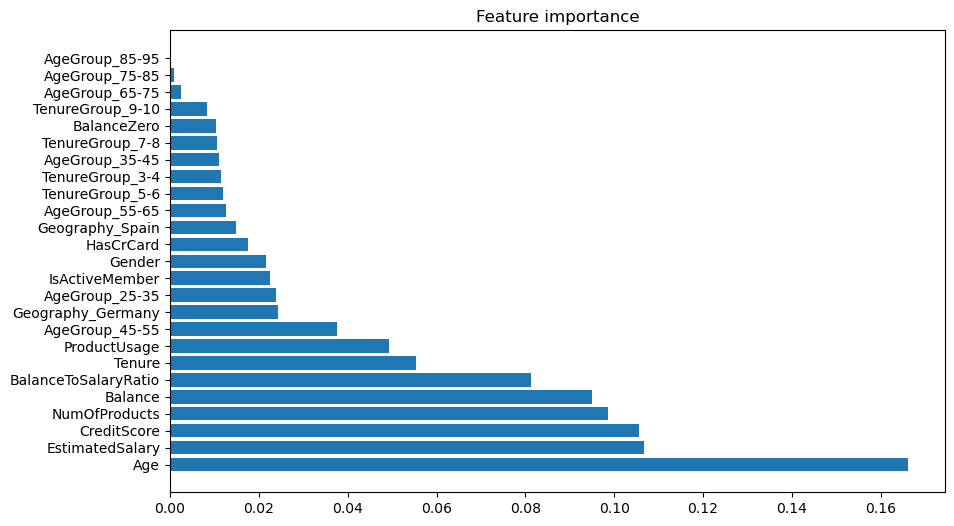

In [473]:
importances = RandomForest_model.feature_importances_
indices = np.argsort(importances)[::-1] #sort the indices and give it in decending order
names =[features[i] for i in indices]

plt.figure(figsize = (10,6))
plt.title("Feature importance")
plt.barh(range(x.shape[1]),importances[indices])
plt.yticks(range(x.shape[1]),names)
plt.show()

# Logistic Regression Model

In [476]:
#build and train the Logistic Regression model
log_reg_model = LogisticRegression(random_state = 42)
log_reg_model.fit(x_train ,y_train)

#make predictions
y_pred_log_reg = log_reg_model.predict(x_test)

#evaluate the model
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test , y_pred_log_reg)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)



In [478]:
print(conf_matrix_log_reg)

[[1539   68]
 [ 264  129]]


In [480]:
print(class_report_log_reg)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1607
           1       0.65      0.33      0.44       393

    accuracy                           0.83      2000
   macro avg       0.75      0.64      0.67      2000
weighted avg       0.81      0.83      0.81      2000



In [482]:
print(accuracy_log_reg)

0.834


# SVM(Support Vector Machine) Model

In [485]:
svm_model = SVC( kernel='linear',random_state=42)
svm_model.fit(x_train , y_train)

SVC(kernel='linear', random_state=42)

In [486]:
y_pred_svm = svm_model.predict(x_test)

In [487]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test,y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

In [488]:
print(conf_matrix_svm)

[[1469  138]
 [ 268  125]]


In [489]:
print(class_report_svm)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1607
           1       0.48      0.32      0.38       393

    accuracy                           0.80      2000
   macro avg       0.66      0.62      0.63      2000
weighted avg       0.77      0.80      0.78      2000



In [494]:
print(accuracy_svm)

0.797


# K Nearest Neighbore Model

In [498]:
knn_model= KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train , y_train)

KNeighborsClassifier()

In [500]:
y_pred_knn = knn_model.predict(x_test)

In [501]:
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)
accuracy_knn = accuracy_score(y_test , y_pred_knn)

In [502]:
print(conf_matrix_knn)

[[1514   93]
 [ 246  147]]


In [506]:
print(class_report_knn)

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1607
           1       0.61      0.37      0.46       393

    accuracy                           0.83      2000
   macro avg       0.74      0.66      0.68      2000
weighted avg       0.81      0.83      0.81      2000



In [508]:
print(accuracy_knn)

0.8305


# Randome forest model (gemini)

In [ ]:
# 1. Initialize the Random Forest Classifier
# We use class_weight='balanced' to handle the class imbalance (Exited=1)
rf_clf = RandomForestClassifier(
    random_state=42,
    # Crucial for imbalance: automatically adjusts weights inversely proportional
    # to class frequencies in the input data.
    
)

# 2. Define the Hyperparameter Grid for Randomized Search
# Focus on parameters that control the number of trees and their depth/complexity
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [10, 20, 30, None], # None means nodes are expanded until all leaves are pure
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.8, 1.0] # Number of features to consider for best split
}

# 3. Perform Randomized Search with Cross-Validation
# We optimize for F1-score, a better metric than accuracy for imbalance
random_search = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_grid,
    n_iter=50,                  # Number of parameter settings sampled
    scoring='f1',               # Metric to optimize (F1-Score for the minority class)
    cv=5,                       # 5-fold cross-validation
    verbose=1,                  # Display progress
    random_state=42,
    n_jobs=-1                   # Use all available CPU cores
)

print("Starting Random Forest Randomized Search (Optimizing for F1-Score)...")
random_search.fit(x_train, y_train)

# Get the best estimator found
best_rf_model = random_search.best_estimator_
print("\n--- Training Complete ---")
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best Cross-Validation F1-Score: {random_search.best_score_:.4f}")

# 4. Final Evaluation on the Test Set
# --- Predict Probabilities ---
y_pred_proba = best_rf_model.predict_proba(x_test)[:, 1]

# --- Calculate AUC-ROC ---
test_auc_roc = roc_auc_score(y_test, y_pred_proba)

# --- Determine F1-Score and Accuracy (using a standard 0.5 threshold) ---
# Since we optimized for F1-score using class_weight='balanced', we can start with 0.5
y_pred = best_rf_model.predict(x_test)

final_accuracy = accuracy_score(y_test, y_pred)
final_f1_score = f1_score(y_test, y_pred)
final_cm = confusion_matrix(y_test, y_pred)

print(f"\nFinal Test Accuracy: {final_accuracy:.4f} (Compare to your 86.35%)")
print(f"Final Test F1-Score (Minority Class): {final_f1_score:.4f}")
print(f"Final Test AUC-ROC Score: {test_auc_roc:.4f} (Robustness metric)")
print("Confusion Matrix (Predicted vs Actual):\n", final_cm)

# 5. Save the Best Model for Deployment
joblib.dump(best_rf_model, 'final_random_forest_churn_model.pkl')
print("\nBest Random Forest model saved as 'final_random_forest_churn_model.pkl'")

Starting Random Forest Randomized Search (Optimizing for F1-Score)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
